# Cointegration Tests

## Imports & Settings

In [70]:
import os
import sys
import requests
import io
import warnings
from time import time
from collections import defaultdict
from pathlib import Path
import pandas as pd
import pandas_datareader.data as web
from scipy.stats import pearsonr
from sklearn.model_selection import cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import scale
from sklearn.metrics import confusion_matrix, mean_squared_error
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.linear_model import LinearRegression, LogisticRegressionCV
from scipy.stats import spearmanr

from alpha_vantage.cryptocurrencies import CryptoCurrencies
import numpy as np
from numpy.linalg import LinAlgError

import statsmodels.api as sm
import statsmodels.tsa.api as tsa
from statsmodels.tsa.stattools import acf, q_stat, adfuller, coint
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.tsa.api import VAR
from statsmodels.stats.diagnostic import het_white

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

In [309]:
pd.set_option('display.float_format', lambda x: f'{x:,.2f}')
warnings.filterwarnings('ignore')

In [47]:
DATA_PATH = Path('..', 'data') 

### Johansen Test Critical Values

In [48]:
critical_values = {0: {.9: 13.4294, .95: 15.4943, .99: 19.9349},
                   1: {.9: 2.7055, .95: 3.8415, .99: 6.6349}}

In [49]:
trace0_cv = critical_values[0][.95] # critical value for 0 cointegration relationships
trace1_cv = critical_values[1][.95] # critical value for 1 cointegration relationship

## Load & Clean Stock & ETF Data

### Remove highly correlated assets

In [ ]:
def remove_correlated_assets(df, cutoff=.99):
    corr = df.corr().stack()
    corr = corr[corr < 1]
    to_check = corr[corr.abs() > cutoff].index
    keep, drop = set(), set()
    for s1, s2 in to_check:
        if s1 not in keep:
            if s2 not in keep:
                keep.add(s1)
                drop.add(s2)
            else:
                drop.add(s1)
        else:
            keep.discard(s2)
            drop.add(s2)
    return df.drop(drop, axis=1)

### Remove stationary series

In [ ]:
def check_stationarity(df):
    results = []
    for symbol, prices in df.items():
        results.append([symbol, adfuller(prices, regression='ct')[1]])
    return pd.DataFrame(results, columns=['symbol', 'adf']).sort_values('adf')

In [ ]:
def remove_stationary_assets(df, pval=.05):
    test_result = check_stationarity(df)
    stationary = test_result.loc[test_result.adf <= pval, 'symbol'].tolist()
    # print(len(stationary_etfs))
    return df.drop(stationary, axis=1).sort_index()

### Select Assets

In [ ]:
def select_assets(asset_class='stocks', n=500, start=2010, end=2019):
    idx = pd.IndexSlice
    with pd.HDFStore('stooq.h5') as store:
        df = (store[f'us/nasdaq/{asset_class}/prices']
                  .append(store[f'us/nyse/{asset_class}/prices'])
                  .drop('openint', axis=1)
                  .sort_index()
                  .loc[idx[:, str(start): str(end)], :])
        df = df.reset_index().drop_duplicates().set_index(['symbol', 'date'])
        df['dv'] = df.close.mul(df.volume)
        dv = df.groupby(level='symbol').dv.mean().nlargest(n=n).index
        df = (df.loc[idx[dv, :], 'close']
              .unstack('symbol')
              .ffill(limit=5)
              .dropna(axis=1))

    df = remove_correlated_assets(df)
    return remove_stationary_assets(df).sort_index()

In [ ]:
for asset_class, n in [('etfs', 500), ('stocks', 250)]:
    df = select_assets(asset_class=asset_class, n=n)
    df.to_hdf('data.h5', f'{asset_class}/close')

### Get symbol dictionary

In [54]:
def get_ticker_dict():
    with pd.HDFStore('stooq.h5') as store:
        return (store['us/nysemkt/stocks/symbols']
                .append(store['us/nyse/stocks/symbols'])
                .append(store['us/nyse/etfs/symbols'])
                .append(store['us/nasdaq/etfs/symbols'])
                .append(store['us/nasdaq/stocks/symbols'])
                .append(store['us/nysemkt/stocks/symbols'])
                .drop_duplicates()
                .set_index('symbol')
                .squeeze()
                .to_dict())

In [216]:
names = get_ticker_dict()

## Visualize Correlation Clusters 

In [214]:
stocks = pd.read_hdf('data.h5', 'stocks/close')
stocks.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2516 entries, 2010-01-04 to 2019-12-31
Columns: 168 entries, AA to YUM
dtypes: float64(168)
memory usage: 3.2 MB


In [215]:
etfs = pd.read_hdf('data.h5', 'etfs/close')
etfs.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2516 entries, 2010-01-04 to 2019-12-31
Columns: 138 entries, AAXJ to YCS
dtypes: float64(138)
memory usage: 2.7 MB


In [217]:
symbols = {k: v for k, v in names.items() if k in etfs.columns.union(stocks.columns)}

In [35]:
corr = pd.DataFrame(index=stocks.columns)
for etf, data in etfs.items():
    corr[etf] = stocks.corrwith(data)

In [36]:
corr.info()

<class 'pandas.core.frame.DataFrame'>
Index: 168 entries, AA to YUM
Columns: 138 entries, AAXJ to YCS
dtypes: float64(138)
memory usage: 187.4+ KB


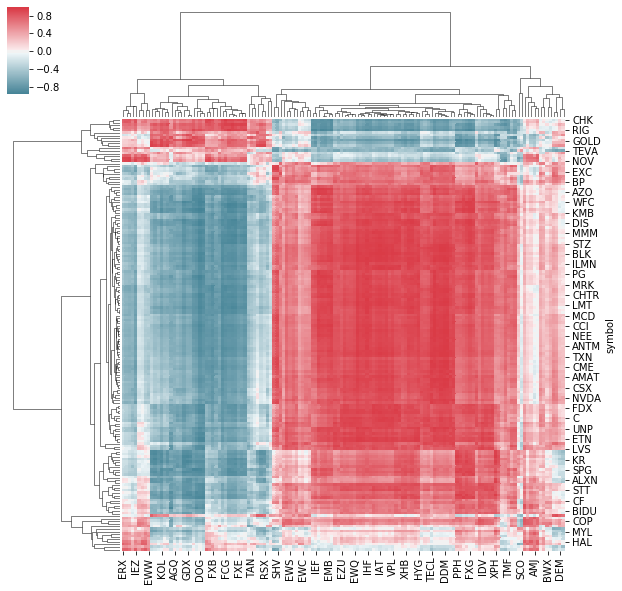

In [37]:
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.clustermap(corr, cmap=cmap, center=0);

## Candidate Selection using Heuristics

### Computational Complexity: Comparison

In [237]:
stocks.shape, etfs.shape

((2516, 168), (2516, 138))

In [222]:
security = etfs['AAXJ'].loc['2010': '2013']
candidates = stocks.loc['2010': '2013']

In [223]:
security = security.div(security.iloc[0])
symbol = security.name
candidates = candidates.div(candidates.iloc[0])
spreads = candidates.sub(security, axis=0)

In [228]:
n, m = spreads.shape
X = np.ones(shape=(n, 2))
X[:, 1] = np.arange(1, n+1)

#### Heuristics

In [229]:
%%timeit
np.linalg.inv(X.T @ X) @ X.T @spreads

666 µs ± 124 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [230]:
%%timeit
spreads.std()

962 µs ± 56.5 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [232]:
%%timeit
candidates.corrwith(security)

28.3 ms ± 187 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


#### Cointegration Tests

In [233]:
%%timeit
for candidate, prices in candidates.items():
    df = pd.DataFrame({'s1': security,
                       's2': prices})
    var = VAR(df)
    lags = var.select_order()
    k_ar_diff = lags.selected_orders['aic']
    coint_johansen(df, det_order=0, k_ar_diff=k_ar_diff)
    coint(security, prices, trend='c')[:2]
    coint(prices, security, trend='c')[:2]

30.7 s ± 2.31 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Compute Heuristics

In [ ]:
def compute_pair_metrics(security, candidates):
    security = security.div(security.iloc[0])
    symbol = security.name
    candidates = candidates.div(candidates.iloc[0])
    spreads = candidates.sub(security, axis=0)
    n, m = spreads.shape
    X = np.ones(shape=(n, 2))
    X[:, 1] = np.arange(1, n + 1)
    drift = ((np.linalg.inv(X.T @ X) @ X.T @ spreads).iloc[1]
             .to_frame('drift'))
    vol = spreads.std().to_frame('vol')
    corr_ret = (candidates.pct_change()
                .corrwith(security.pct_change())
                .to_frame('corr_ret'))
    corr = candidates.corrwith(security).to_frame('corr')
    metrics = drift.join(vol).join(corr).join(corr_ret).assign(n=n)
    tests = []
    for candidate, prices in candidates.items():
        df = pd.DataFrame({'s1': security, 's2': prices})
        var = VAR(df)
        lags = var.select_order() # select VAR order
        k_ar_diff = lags.selected_orders['aic']
        # Johansen Test with constant Term and estd. lag order
        cj0 = coint_johansen(df, det_order=0, k_ar_diff=k_ar_diff)
        # Engle-Granger Tests
        t1, p1 = coint(security, prices, trend='c')[:2]
        t2, p2 = coint(prices, security, trend='c')[:2]
        tests.append([symbol, candidate, t1, p1, t2, p2, 
                      k_ar_diff, *cj0.lr1])
    columns = ['s1', 's2', 't1', 'p1', 't2', 'p2', 'k_ar_diff', 'trace0', 'trace1']
    tests = pd.DataFrame(tests, columns=columns).set_index('s2')
    return metrics.join(tests)

In [ ]:
spreads = []
start = 2010
stop = 2019
etf_candidates = etfs.loc[str(start): str(stop), :]
stock_candidates = stocks.loc[str(start): str(stop), :]
s = time()
for i, (etf_symbol, etf_prices) in enumerate(etf_candidates.items(), 1):
    df = compute_pair_metrics(etf_prices, stock_candidates)
    spreads.append(df.set_index('s1', append=True))
    if i % 10 == 0:
        print(f'{i:>3} {time() - s:.1f}')
        s = time()

In [241]:
names = get_ticker_dict()
spreads = pd.concat(spreads)
spreads.index.names = ['s2', 's1']
spreads = spreads.swaplevel()
spreads['name1'] = spreads.index.get_level_values('s1').map(names)
spreads['name2'] = spreads.index.get_level_values('s2').map(names)

In [242]:
spreads['t'] = spreads[['t1', 't2']].min(axis=1)
spreads['p'] = spreads[['p1', 'p2']].min(axis=1)

### Engle-Granger vs Johansen: Comparison

In [243]:
spreads['trace_sig'] = ((spreads.trace0 > trace0_cv) &
                        (spreads.trace1 > trace1_cv)).astype(int)
spreads['eg_sig'] = (spreads.p < .05).astype(int)

In [288]:
pd.crosstab(spreads.eg_sig, spreads.trace_sig)

trace_sig,0,1
eg_sig,,
0,42212,1100
1,2690,366


In [245]:
spreads['coint'] = (spreads.trace_sig & spreads.eg_sig).astype(int)

In [298]:
spreads.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46368 entries, 0 to 46367
Data columns (total 21 columns):
s1           46368 non-null object
s2           46368 non-null object
drift        46368 non-null float64
vol          46368 non-null float64
corr         46368 non-null float64
corr_ret     46368 non-null float64
n            46368 non-null int64
t1           46368 non-null float64
p1           46368 non-null float64
t2           46368 non-null float64
p2           46368 non-null float64
k_ar_diff    46368 non-null int64
trace0       46368 non-null float64
trace1       46368 non-null float64
name1        46368 non-null object
name2        46368 non-null object
t            46368 non-null float64
p            46368 non-null float64
trace_sig    46368 non-null int64
eg_sig       46368 non-null int64
coint        46368 non-null int64
dtypes: float64(12), int64(5), object(4)
memory usage: 7.4+ MB


In [296]:
spreads = spreads.reset_index()

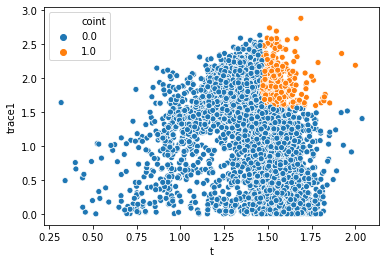

In [297]:
sns.scatterplot(x=np.log1p(spreads.t.abs()), 
                y=np.log1p(spreads.trace1), 
                hue='coint', data=spreads[spreads.trace0>trace0_cv]);

In [299]:
spreads.to_hdf('heuristics.h5', 'spreads')

In [300]:
spreads = pd.read_hdf('heuristics.h5', 'spreads')

### Evaluate Heuristics

In [275]:
spreads.drift = spreads.drift.abs()

In [303]:
pd.crosstab(spreads.eg_sig, spreads.trace_sig)

trace_sig,0,1
eg_sig,,
0,42212,1100
1,2690,366


In [308]:
pd.set_option('display.float_format', lambda x: f'{x:.2%}')
pd.crosstab(spreads.eg_sig, spreads.trace_sig, normalize=True)

trace_sig,0,1
eg_sig,,
0,91.04%,2.37%
1,5.80%,0.79%


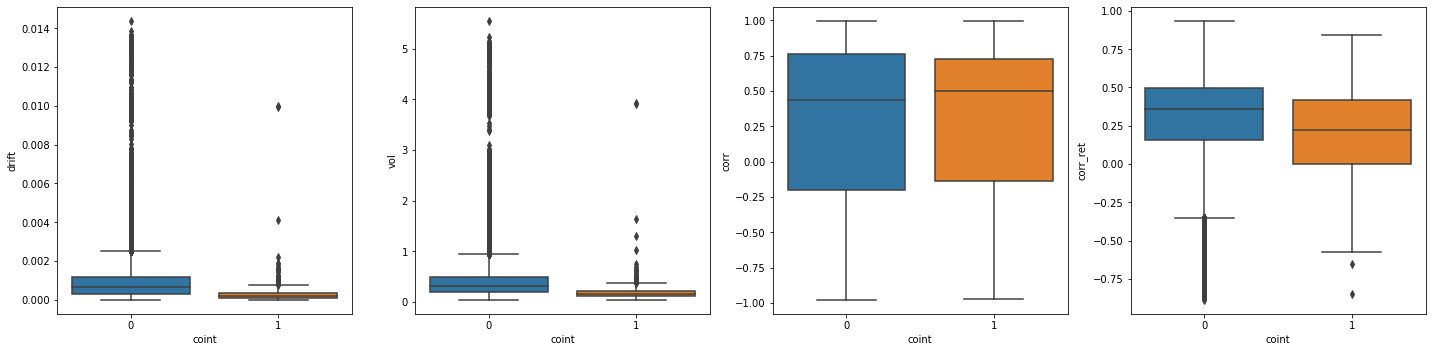

In [346]:
fig, axes = plt.subplots(ncols=4, figsize=(20, 5))
for i, heuristic in enumerate(['drift', 'vol', 'corr', 'corr_ret']):
    sns.boxplot(x='coint', y=heuristic, data=spreads, ax=axes[i])
fig.tight_layout()
fig.savefig('figures/heuristics_boxplot', dpi=300)

### How well do the heuristics predict significant cointegration?

In [249]:
spreads.groupby(spreads.coint)['drift', 'vol', 'corr'].describe().stack(level=0).swaplevel().sort_index()

25%       50%       75%    count       max      mean  \
      coint                                                              
corr  0      0.081694  0.275819  0.405091  22548.0  0.919731  0.232810   
      1      0.171335  0.341867  0.434177    636.0  0.852903  0.259837   
drift 0     -0.000238  0.000299  0.000956  22548.0  0.004802  0.000420   
      1     -0.000121  0.000049  0.000368    636.0  0.002820  0.000174   
vol   0      0.125940  0.177821  0.253893  22548.0  0.979135  0.211136   
      1      0.074093  0.101142  0.166579    636.0  0.559241  0.135143   

                  min       std  
      coint                      
corr  0     -0.853566  0.246004  
      1     -0.799849  0.268331  
drift 0     -0.003910  0.000948  
      1     -0.001086  0.000532  
vol   0      0.026601  0.124725  
      1      0.034979  0.092224

In [250]:
spreads.coint.value_counts()

0    22548
1      636
Name: coint, dtype: int64

#### Logistic Regression

In [368]:
y = spreads.coint
X = spreads[['drift', 'vol', 'corr', 'corr_ret']]
# X = spreads[['drift', 'vol']]

In [358]:
kf = StratifiedKFold(n_splits=5, shuffle=True)

In [359]:
log_reg = LogisticRegressionCV(Cs=np.logspace(-10, 10, 21), 
                               class_weight='balanced',
                               scoring='roc_auc')

'C:1.00, AUC: 81.53%'

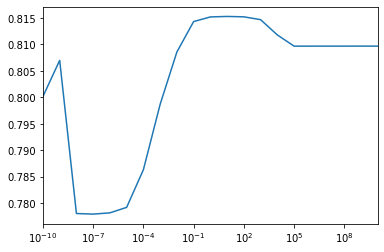

In [361]:
log_reg.fit(X=X, y=y)
Cs = log_reg.Cs_
scores = pd.DataFrame(log_reg.scores_[True], columns=Cs).mean()
scores.plot(logx=True);
f'C:{np.log10(scores.idxmax()):.2f}, AUC: {scores.max():.2%}'

In [362]:
log_reg.coef_

array([[-1.50860732, -4.27830829,  0.0478216 , -1.46489095]])

In [382]:
y_pred = log_reg.predict_proba(X)[:, 1]
confusion_matrix(y_true=spreads.coint, y_pred=(y_pred>.5))

array([[29420, 16582],
       [   55,   311]])

In [257]:
spreads.assign(y_pred=log_reg.predict_proba(X)[:, 1]).groupby(spreads.coint).y_pred.describe()

,count,mean,std,min,25%,50%,75%,max
coint,,,,,,,,
0,22548.0,0.440611,0.168162,0.002649,0.343832,0.476786,0.571714,0.734107
1,636.0,0.559391,0.144166,0.053791,0.495931,0.616350,0.662464,0.722277


#### Decision Tree Classifier

In [369]:
model = DecisionTreeClassifier(class_weight='balanced')
decision_tree = GridSearchCV(model,
                             param_grid={'max_depth': list(range(1, 10))},
                             cv=5,
                             scoring='roc_auc')

In [370]:
decision_tree.fit(X=X, y=y)
f'{best_tree.best_score_:.2%}, Depth: {best_tree.best_params_["max_depth"]}'

'82.21%, Depth: 4'

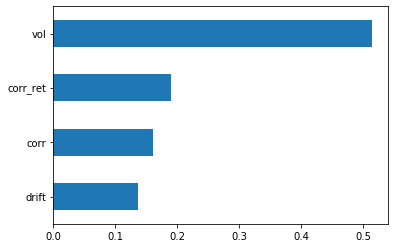

In [371]:
pd.Series(data=decision_tree.best_estimator_.feature_importances_, index=X.columns).sort_values().plot.barh();

In [336]:
spreads.assign(y_pred=decision_tree.predict_proba(X)[:, 1]).groupby(spreads.coint).y_pred.describe()

,count,mean,std,min,25%,50%,75%,max
coint,,,,,,,,
0,"46,002.00",0.26,0.27,0.00,0.05,0.15,0.49,0.93
1,366.00,0.74,0.23,0.05,0.60,0.87,0.93,0.93


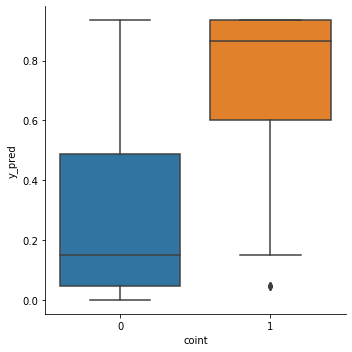

In [344]:
sns.catplot(x='coint', 
            y='y_pred', 
            data=spreads.assign(y_pred=decision_tree.predict_proba(X)[:, 1]), 
            kind='box');